In [1]:
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, load_digits
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision.transforms.functional import rotate
from scipy import ndimage

In [986]:
#Redefine the MMD function we defined at last assignment with tensor form
def squared_distances(X, Y):
    """
    Compute the squared Euclidean distances between each pair of points in the two datasets X and Y.

    :param X: Array of shape (n_samples_X, n_features).
    :param Y: Array of shape (n_samples_Y, n_features).
    :return: Matrix of shape (n_samples_X, n_samples_Y) where each element represents the squared distance.
    """
    # Expand the squares of X and Y
    X_square = torch.sum(X**2, dim=1, keepdim=True)
    Y_square = torch.sum(Y**2, dim=1, keepdim=True)

    # Compute the squared distances
    squared_dist = X_square  -2 * torch.matmul(X, Y.t()) + Y_square.t()
    return squared_dist

def se_kernel_custom(X, Y, gamma=None):
    """
    Compute the Radial Basis Function (RBF) kernel (squared exponential) between each pair of points in X and Y.

    :param X: First dataset.
    :param Y: Second dataset.
    :param gamma: Gamma parameter for the RBF kernel. If None, it's set to 1/n_features.
    :return: RBF kernel matrix.
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]  # 1/n_features

    sq_dists = squared_distances(X, Y)
    return torch.exp(-gamma * sq_dists)

def compute_mmd(kernel_XX, kernel_YY, kernel_XY):
    """
    Compute the MMD value from the kernel matrices.
    :param kernel_XX: Kernel matrix among samples in X.
    :param kernel_YY: Kernel matrix among samples in Y.
    :param kernel_XY: Kernel matrix between samples in X and Y.
    :return: MMD value.
    """
    mmd_square = torch.mean(kernel_XX) + torch.mean(kernel_YY) - 2 * torch.mean(kernel_XY)
    return torch.sqrt(mmd_square)  # Return the square root to get MMD

In [1002]:
class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks
        self.skip_connection_dimension = int(np.floor(input_size / 2))
        self.transform_dimension = int(input_size - self.skip_connection_dimension)
        
        self.scalling_coefficient_network = nn.ModuleList([nn.Sequential(
            *[nn.Linear(self.skip_connection_dimension, self.hidden_size),
              nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              nn.Linear(self.hidden_size, self.transform_dimension),
              nn.Tanh()]
        ) for l in range(self.blocks)])
        
        self.translation_coefficient_network = nn.ModuleList([nn.Sequential(
            *[nn.Linear(self.skip_connection_dimension, self.hidden_size),
              nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              nn.Linear(self.hidden_size, self.transform_dimension)]
        ) for l in range(self.blocks)])
    
    def decode(self, Z, Qs):
        Qs = list(reversed(Qs))
        reversed_scalling_coefficient_network = list(reversed(self.scalling_coefficient_network))
        revesed_translation_coefficient_network = list(reversed(self.translation_coefficient_network))
        X_previous = Z
        for l in range(self.blocks):
            X_skip = X_previous[:, :self.skip_connection_dimension]
            X_transform = X_previous[:, self.skip_connection_dimension:]
            s_tilde = reversed_scalling_coefficient_network[l](X_skip)
            s = torch.exp(-s_tilde)
            t = revesed_translation_coefficient_network[l](X_skip)
            X_transformed = torch.mul(X_transform - t, s)
            X_previous = torch.cat((X_skip, X_transformed), axis=1)
            if l < self.blocks - 1:
                X = torch.tensor(X_previous.detach().numpy() @ Qs[l].T)
                X_previous = X
        return X_previous
            

    
    def encode(self, X):
        Z_previous = X
        log_det = 0
        random_Qs = []
        for l in range(self.blocks):
            Z_skip = Z_previous[:, :self.skip_connection_dimension]
            Z_transform = Z_previous[:, self.skip_connection_dimension:]
            s_tilde = self.scalling_coefficient_network[l](Z_skip)
            s = torch.exp(s_tilde)
            t = self.translation_coefficient_network[l](Z_skip)
            Z_transformed = torch.mul(Z_transform, s) + t
            Z_previous = torch.cat((Z_skip, Z_transformed), axis=1)
            
            if l < self.blocks - 1:
                random_matrix = np.random.randn(self.input_size, self.input_size)
                random_Q = np.linalg.qr(random_matrix)[0]
                random_Q = random_Q.astype(np.float32)
                random_Qs.append(random_Q)
                Z = torch.tensor(Z_previous.detach().numpy() @ random_Q )
                Z_previous = Z
            log_det += torch.sum(torch.sum(s_tilde))
    
        return Z_previous, log_det, random_Qs

            
    
    def train_inn(self, X_train,  ts_size, epochs, lr=0.001, batch_size=128, reported_loss = "MIN"):
           # assert ts_size % batch_size == 0
           # assert batch_size % 2 == 0
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
            losses = []
            for epoch in range(epochs):
                gamma = 5.5
                weight = 0.01
                indices = torch.randperm(len(X_train))[:ts_size]
                X_train = X_train[indices]
                batch_losses = []
                Z, log_det, _ = self.encode(X_train)
                loss = 0
                for z in Z:
                    loss += torch.matmul(z.T, z)/2
                    #print(torch.matmul(z.T, z)/2)
                #print(loss, log_det)
                loss -= log_det
                loss /= ts_size 
                          #Loss_mse
                #Loss_MMD
                kernel_XX_se = se_kernel_custom(Z, Z,gamma=gamma)
                kernel_YY_se = se_kernel_custom(X_train, X_train,gamma=gamma)
                kernel_XY_se = se_kernel_custom(Z, X_train,gamma=gamma)
                loss_MMD=compute_mmd(kernel_XX_se, kernel_YY_se, kernel_XY_se)
                #Loss_total
                loss=weight*loss+(1-weight)*loss_MMD
                #loss = (torch.matmul(Z.T, Z)**2 / 2).mean() - (log_det/ts_size)

            
               
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())

                #for batch in range(0, ts_size - batch_size, batch_size):
                #    X_batch = X_train[batch : batch + batch_size]
                #    Z, log_det, _ = self.encode(X_batch)
                #    loss = sum((torch.square(Z) / 2) - log_det).mean()
                #    batch_losses.append(loss.detach().numpy())
                #    optimizer.zero_grad()
                #    loss.backward()
                #    optimizer.step()
                #if reported_loss == "MIN":
                #    losses.append(min(batch_losses))
                #elif reported_loss == "MAX":
                #    losses.append(max(batch_losses))


            return self, np.array(losses)

        
        

In [690]:
def import_data(noise=0, random_state=1, shuffle=True, n_test=0.5, name="moons", n_samples = 2000):
    if name == "moons":
        data, _ = make_moons(noise=noise, random_state=random_state, shuffle=shuffle, n_samples=n_samples)
        X_train, X_test= train_test_split(data, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), None, None

    elif name == "digits":
        data, labels = load_digits(return_X_y = True)
        data = data.reshape((len(data), -1))
        noise =  np.random.normal(0, noise * data.max(), data.shape)
        X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(Y_train), torch.FloatTensor(Y_test)

In [691]:
X_train, X_test, Y_train, Y_test = import_data(noise=0.1, n_test=0.5,  name="moons")

In [1004]:
nvp, losses = RealNVP(2, 50, 2).train_inn(X_train, 100, 200)

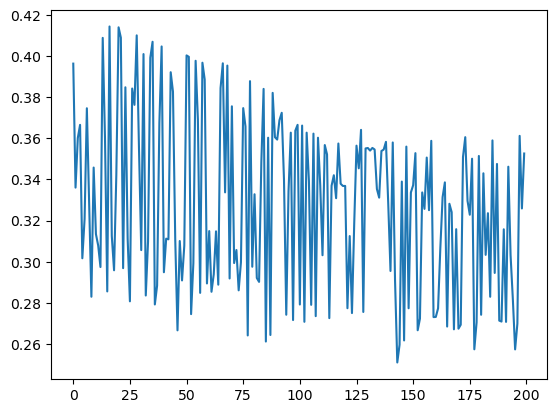

In [1005]:
plt.plot(losses)

In [1000]:
Z,_, Qs = nvp.encode(X_test)
reconstruced = nvp.decode(Z, Qs)
reconstruced = reconstruced.detach().numpy()
Z = Z.detach().numpy()

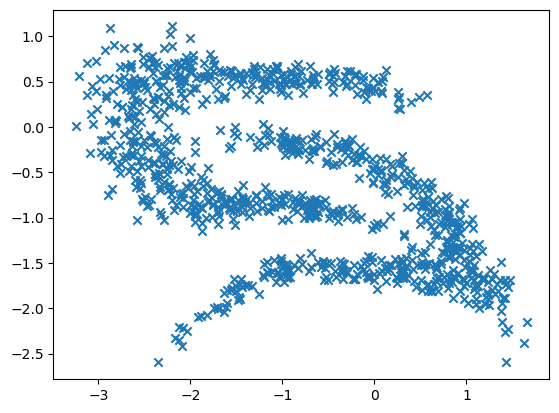

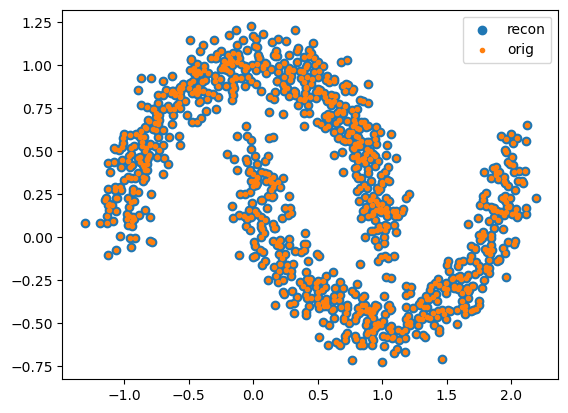

In [1001]:
#plt.imshow(X_test[0].reshape(8, 8))
#plt.figure()
#plt.imshow(Z[0].reshape(8,8))
#plt.figure()
#plt.imshow(reconstruced[0].reshape(8,8))
plt.scatter(Z[:, 0], Z[:, 1], label="Z", marker="x")
plt.figure()
plt.scatter(reconstruced[:, 0], reconstruced[:, 1], label="recon")
plt.scatter(X_test[:, 0], X_test[:, 1], label="orig", marker=".")
plt.legend()